In [73]:
import numpy as np
import pandas as pd
import os
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv('../runs/results.csv')
# df = pd.read_csv('../runs/results_.csv')
df = df.replace({'apply_patch': 'True', 'random_patch': 'True'}, 1)
df = df.replace({'apply_patch': 'False', 'random_patch': 'False'}, 0)
for col in ['apply_patch', 'random_patch']:
    df[col] = df[col].astype(float).astype(bool)

df[['fnr_octagon', 'num_octagon_labels', 'num_octagon_with_patch', 'fn_octagon', 'apply_patch', 'generate_patch']].iloc[[2, 0, 4]]
# df[['fnr_octagon', 'num_octagon_labels', 'num_octagon_with_patch', 'fn_octagon', 'apply_patch', 'generate_patch']]

,fnr_octagon,num_octagon_labels,num_octagon_with_patch,fn_octagon,apply_patch,generate_patch
2,0.206545,885.0,0.0,183.0,False,NaN
0,0.247797,885.0,571.0,219.0,True,real
4,0.275403,885.0,571.0,244.0,True,real


In [85]:
# f = open('../runs/val/exp/bg_filenames.txt', 'r')
# lines = f.readlines()
# bg_filenames = [x.strip('\n') for x in lines]
# print(bg_filenames)

df_results_per_label_no_patch = pd.read_csv('../runs/val/exp_mapillary_no_patch_0/results_per_label.csv')
df_results_per_label_rp2_patch = pd.read_csv('../runs/val/exp_mapillary_rp2_patch_3/results_per_label.csv')

merged_df = df_results_per_label_no_patch.merge(df_results_per_label_rp2_patch, on=['filename', 'obj_id', 'sign_width', 'sign_height'], suffixes=['_no_patch', '_patch'])
assert len(merged_df) == len(df_results_per_label_rp2_patch) & len(merged_df) == len(df_results_per_label_no_patch)

merged_df = merged_df[merged_df['correct_prediction_no_patch'] == 1]
merged_df['fn'] = merged_df['correct_prediction_no_patch'] - merged_df['correct_prediction_patch']
merged_df = merged_df.sort_values(by=['fn', 'filename'], ascending=[False, True])
merged_df
# successful_attack_filenames = set(merged_df[merged_df['change_in_fn'] > 0]['filename'])
# len(successful_attack_filenames_2)

# merged_df[merged_df['filename'].isin(bg_filenames)]

merged_df['avg_sign_dim'] = (merged_df['sign_width'] + merged_df['sign_height'])/2
merged_df

,filename,obj_id,label_no_patch,correct_prediction_no_patch,sign_width,sign_height,confidence_no_patch,label_patch,correct_prediction_patch,confidence_patch,fn,avg_sign_dim
614,-LtOhSguWQXyerbzUN6HpA.jpg,5.0,14.0,1,60.784359,56.862732,0.918845,14.0,0,0.238925,1,58.823545
130,-gSMw1gvzaUryheHPx00Zw.jpg,5.0,14.0,1,9.166687,26.388916,0.777415,14.0,0,0.345203,1,17.777802
127,04_G_l3AleUQWBSJ4_R8Hw.jpg,2.0,14.0,1,24.666655,118.000000,0.700801,14.0,0,0.130750,1,71.333327
606,056PRDIdH73i9SjAk2zT1w.jpg,6.0,14.0,1,99.215698,90.196106,0.913505,14.0,0,0.240098,1,94.705902
117,1ZVr4WwP3wSKYu16SLIvDg.jpg,2.0,14.0,1,22.745056,25.490204,0.865474,14.0,0,0.295811,1,24.117630
...,...,...,...,...,...,...,...,...,...,...,...,...
362,z615WCsFY5ZFmu4l5BADUw.jpg,2.0,14.0,1,46.999969,44.500000,0.933075,14.0,1,0.740166,0,45.749985
352,zTOpBElZV7sYDKSdAITHHw.jpg,0.0,14.0,1,62.352909,56.078430,0.911784,14.0,1,0.785951,0,59.215670
353,zUmpHOqZRnu2eAeUBQFWkQ.jpg,5.0,14.0,1,35.686279,38.039246,0.905545,14.0,1,0.830811,0,36.862762
354,zpOQfvo3deAc_qQK7yssjw.jpg,1.0,14.0,1,11.887549,11.566345,0.760282,14.0,1,0.760282,0,11.726947


In [76]:
# # checking results per label are correct
# df_results_per_image = pd.read_csv('../runs/val/exp_mapillary_rp2_patch_0/results_per_image.csv')
# print(np.sum(df_results_per_image['fn']))

# print(len(df_results_per_label_rp2_patch) - np.sum(df_results_per_label_rp2_patch['correct_prediction']))


In [77]:
np.sum(merged_df['fn'])/571

0.11208406304728546

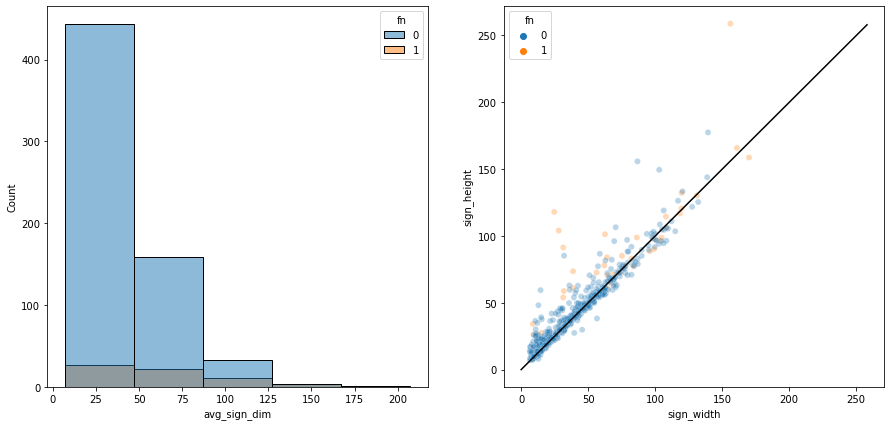

In [83]:
f, ax = plt.subplots(1, 2)
f.set_figheight(7)
f.set_figwidth(15)

sns.histplot(data=merged_df[merged_df['fn'] >= 0], x="avg_sign_dim", hue='fn', bins=5, ax=ax[0])
sns.scatterplot(x='sign_width', y='sign_height', data=merged_df[merged_df['fn'] >= 0], hue='fn', alpha=0.3, ax=ax[1])
ax[1].plot(np.arange(0, max(merged_df[merged_df['fn'] >= 0]['sign_height'])), np.arange(0, max(merged_df[merged_df['fn'] >= 0]['sign_height'])), color='black')

(0.0, 1.0)

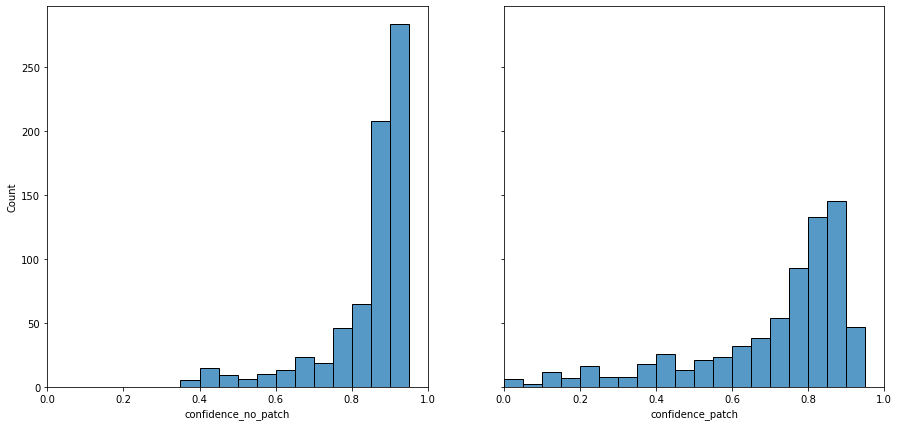

In [79]:
f, ax = plt.subplots(1, 2, sharey=True)
f.set_figheight(7)
f.set_figwidth(15)

bins=np.arange(0, 1.01, 0.05)
# sns.histplot(data=merged_df[merged_df['fn'] >= 0], x="confidence_no_patch", ax=ax[0], bins=bins)
# sns.histplot(data=merged_df[merged_df['fn'] >= 0], x="confidence_patch", ax=ax[1], bins=bins)

sns.histplot(data=merged_df, x="confidence_no_patch", ax=ax[0], bins=bins)
sns.histplot(data=merged_df, x="confidence_patch", ax=ax[1], bins=bins)

ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)


In [80]:
min(merged_df['confidence_no_patch'])

0.3634558916091919

In [81]:
merged_df['correct_prediction_no_patch'].value_counts()

1    702
Name: correct_prediction_no_patch, dtype: int64

In [82]:
successful_attack_filenames = set(merged_df[merged_df['fn'] > 0]['filename'])
len(successful_attack_filenames)

with open('../runs/successful_attack_filenames.txt', 'w') as f:
    for line in successful_attack_filenames:
        f.write(line)
        f.write('\n')


64